# Agentic Orchestration with MCP and Langgraph Using Amazon Bedrock with OpenAI Proxy

Allows clients to call Amazon Bedrock foundation models using OpenAI-compatible RESTful APIs for Amazon Bedrock. The deployment is based on the [bedrock-access-gateway](https://github.com/aws-samples/bedrock-access-gateway?tab=readme-ov-file)


* Step 1: Create your own API key in Secrets Manager (MUST)

Note: This step is to use any string (without spaces) you like to create a custom API Key (credential) that will be used to access the proxy API later. This key does not have to match your actual OpenAI key, and you don't need to have an OpenAI API key. please keep the key safe and private.
Open the AWS Management Console and navigate to the AWS Secrets Manager service.

    * Click on "Store a new secret" button.
    
    * In the "Choose secret type" page, select:
    
        * Secret type: Other type of secret Key/value pairs:
            * Key: api_key
            * Value: Enter your API key value
            
    * Click "Next"
    
    * In the "Configure secret" page: Secret name: Enter a name (e.g., "BedrockProxyAPIKey") Description: (Optional) Add a description of your secret
    
    * Click "Next" and review all your settings and click "Store"

After creation, you'll see your secret in the Secrets Manager console. Make note of the secret ARN.

* Step 2: Deploy the CloudFormation stack

    * Sign in to AWS Management Console, switch to the region to deploy the CloudFormation Stack to.

    * Click the following button to launch the CloudFormation Stack in that region. Choose one of the following:

     [ALB + Lambda 1-Click Deploy 🚀](https://console.aws.amazon.com/cloudformation/home?#/stacks/quickcreate?templateURL=https://aws-gcr-solutions.s3.amazonaws.com/bedrock-access-gateway/latest/BedrockProxy.template&stackName=BedrockProxyAPI) 
 
     [ALB + Fargate 1-Click Deploy 🚀](https://console.aws.amazon.com/cloudformation/home?#/stacks/quickcreate?templateURL=https://aws-gcr-solutions.s3.amazonaws.com/bedrock-access-gateway/latest/BedrockProxyFargate.template&stackName=BedrockProxyAPI) 

    * Click "Next".
    * On the "Specify stack details" page, provide the following information:
        * Stack name: Change the stack name if needed.
        * ApiKeySecretArn: Enter the secret ARN you used for storing the API key.
        
    * Click "Next".
        * On the "Configure stack options" page, you can leave the default settings or customize them according to your needs. Click "Next".
        * On the "Review" page, review the details of the stack you're about to create. Check the "I acknowledge that AWS CloudFormation might create IAM resources" checkbox at the bottom. Click "Create stack".

That is it! 🎉 Once deployed, click the CloudFormation stack and go to Outputs tab, you can find the API Base URL from APIBaseUrl, the value should look like http://xxxx.xxx.elb.amazonaws.com/api/v1.

In [1]:
from openai import OpenAI
import os
#import boto3
import json
#from botocore.exceptions import ClientError
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY = os.environ["TAVILY_API_KEY"] = os.getenv("tavily_api_token")

In [2]:
prompt = "+++factcheck\n+++Refine(iteration=2)\n+++CiteSources\n How many combined unique letters are adjacent to the 'c' and seperately 'n' in the longest English word?"

In [3]:
os.environ["OPENAI_API_KEY"] = api_key = os.getenv("bedrock_api_token")
os.environ["OPENAI_BASE_URL"] = base_url = os.getenv("bedrock_api_url")

## Simple LLM invoke

In [4]:
client = OpenAI() #api_key=api_key, base_url=base_url)
model_id_c37 = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
model_id_h35 = 'us.anthropic.claude-3-5-haiku-20241022-v1:0'
model_id_c35 = "us.anthropic.claude-3-5-sonnet-20241022-v2:0",
model_id_nova = 'us.amazon.nova-lite-v1:0'
model_id_ds = 'us.deepseek.r1-v1:0'

# Change to your desire model ID
model_id = model_id_c37
completion = client.chat.completions.create(
    model=model_id,
    messages=[{"role": "user", "content": prompt}],
    max_tokens=8196,
)

print(completion.choices[0].message.content)

# Factcheck: How many combined unique letters are adjacent to the 'c' and separately 'n' in the longest English word?

To answer this question, I need to:
1. Identify the longest English word
2. Find all instances of 'c' and 'n' in this word
3. Determine which letters are adjacent to each of these letters
4. Count the unique adjacent letters

## Step 1: Identify the longest English word

The longest English word that is widely recognized is "pneumonoultramicroscopicsilicovolcanoconiosis" (45 letters), which refers to a lung disease caused by inhaling very fine silica dust [1][2].

## Step 2: Find instances of 'c' and 'n' in this word

In "pneumonoultramicroscopicsilicovolcanoconiosis":
- The letter 'c' appears at positions 14, 17, 28, 33, 37, and 40
- The letter 'n' appears at positions 2, 8, 20, 36, and 42

## Step 3: Determine adjacent letters

Letters adjacent to 'c':
- Before position 14: 's'
- After position 14: 'r'
- Before position 17: 's'
- After position 17: 'o'
- Before posit

## Streaming

In [5]:
import time

In [6]:
chat_response = client.chat.completions.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant. Please answer the user question accurately and truthfully. Also please make sure to think carefully before answering"},
        {"role": "user", "content": prompt},
    ],
    stream=True,
    temperature=1.0,
    max_tokens=8196,
)
#for chunk in chat_response:
#    print(chunk.choices[0].delta.content , end="", flush=True) if chunk.choices[0].delta.content else None

start_time = time.time()
# create variables to collect the stream of chunks
collected_chunks = []
collected_messages = []
# iterate through the stream of events
for chunk in chat_response:
    chunk_time = time.time() - start_time  # calculate the time delay of the chunk
    collected_chunks.append(chunk)  # save the event response
    chunk_message = chunk.choices[0].delta.content  # extract the message
    collected_messages.append(chunk_message)  # save the message
    print(f"Message received {chunk_time:.2f} seconds after request: {chunk_message}")  # print the delay and text

# print the time delay and text received
print(f"Full response received {chunk_time:.2f} seconds after request")
# clean None in collected_messages
collected_messages = [m for m in collected_messages if m is not None]
full_reply_content = ''.join(collected_messages)
print(f"Full conversation received: {full_reply_content}")

Message received 0.00 seconds after request: 
Message received 0.00 seconds after request: I
Message received 0.00 seconds after request:  need to think
Message received 0.00 seconds after request:  carefully about this problem
Message received 0.00 seconds after request: :

1
Message received 0.00 seconds after request: . First, I
Message received 0.00 seconds after request:  need to identify
Message received 0.00 seconds after request:  the longest English wor
Message received 0.00 seconds after request: d.
Message received 0.00 seconds after request: 
2. Then
Message received 0.00 seconds after request:  I need to fin
Message received 0.00 seconds after request: d all letter positions where
Message received 0.00 seconds after request:  'c' an
Message received 0.00 seconds after request: d 'n' appear
Message received 0.00 seconds after request: .
3. For
Message received 0.00 seconds after request:  each 'c' an
Message received 0.00 seconds after request: d 'n'
Message received 0.00 s

## Chat with Langchain

In [7]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model=model_id,
    temperature=1.0,
    max_tokens=None,
    timeout=None,
    max_retries=5,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)

llm_nova = ChatOpenAI(
    model=model_id_nova,
    temperature=1.0,
    max_tokens=1024,
    timeout=None,
    max_retries=5,
    # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)

messages = [
    (
        "system",
        "You are a reliable assistant capable of providing truthful and accurate answers to questions.",
    ),
    ("human", prompt),
]
responds = llm.invoke(messages)

In [8]:
responds

AIMessage(content='I\'ll analyze the question step by step.\n\nFirst, I need to find the longest English word. Then I\'ll determine which letters are adjacent to \'c\' and which are adjacent to \'n\' in that word, and count the unique letters in the combined set.\n\nAccording to reliable linguistic sources, the longest English word generally accepted in major dictionaries is "pneumonoultramicroscopicsilicovolcanoconiosis" (45 letters), which refers to a lung disease caused by inhaling very fine silica dust.\n\nLet me identify all the letters adjacent to \'c\' and \'n\' in this word:\n\nLetters adjacent to \'c\' in "pneumonoultramicroscopicsilicovolcanoconiosis":\n- Before \'c\': \'i\' (in "microscopic"), \'s\' (in "microscopic"), \'i\' (in "silico"), \'l\' (in "volcano"), \'a\' (in "volcano"), \'o\' (in "coniosis")\n- After \'c\': \'r\' (in "microscopic"), \'o\' (in "microscopic"), \'s\' (in "silico"), \'o\' (in "volcano"), \'o\' (in "coniosis")\n\nLetters adjacent to \'n\' in "pneumon

## Bind_tools makes easy

In [9]:
from pydantic import BaseModel, Field
#from langchain_community.tools.tavily_search import TavilySearchResults
from tavily import AsyncTavilyClient

async def tavily_search_web(query: str) -> str:
    """Useful for using the web to answer questions"""
    client = AsyncTavilyClient()
    return str(await client.search(query))
    

TAVILY_API_KEY = os.environ["TAVILY_API_KEY"] = os.getenv("tavily_api_token")

# Today
def get_current_time():
    """Returns the current time in MM-dd-YYYY format."""
    import datetime  # Import datetime module to get current time

    now = datetime.datetime.now()  # Get current time
    return now.strftime("%B-%d-%Y")  # Format time in H:MM AM/PM format

tavily_tool = TavilySearchResults(max_results=3)


class GetWeather(BaseModel):
    """Get the current weather in a given location"""

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")


llm_with_tools = llm.bind_tools([get_current_time,tavily_tool])

results = llm_with_tools.invoke(
    "what is the weather like in San Francisco today?",
)
results

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tooluse_kn0S-7LDQjqJaAOxmpU4Eg', 'function': {'arguments': '{"query": "San Francisco weather today current conditions"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 474, 'total_tokens': 577, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0', 'system_fingerprint': 'fp', 'id': 'chatcmpl-b27b4902', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ac012788-15b4-4735-af5a-33f9418a4e3d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'San Francisco weather today current conditions'}, 'id': 'tooluse_kn0S-7LDQjqJaAOxmpU4Eg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 474, 'output_tokens': 103, 'total_tokens': 577, 'input_token_details': {}, 'output_token_details': {}})

In [10]:
print(results.tool_calls)
print(results.content)

[{'name': 'tavily_search_results_json', 'args': {'query': 'San Francisco weather today current conditions'}, 'id': 'tooluse_kn0S-7LDQjqJaAOxmpU4Eg', 'type': 'tool_call'}]



## Streamining, if the model supports it

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_template("Describe the {topic} in scientific manner.")
parser = StrOutputParser()
chain = prompt | llm | parser
respone = chain.invoke({"topic": "parrot"})
respone
'''
async for event in chain.astream_events({"topic": "parrot"}):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        print(event, end="|", flush=True)
'''

'\nasync for event in chain.astream_events({"topic": "parrot"}):\n    kind = event["event"]\n    if kind == "on_chat_model_stream":\n        print(event, end="|", flush=True)\n'

## With multi-agent langgraph

In [12]:
from typing import Annotated
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    checkpointer=MemorySaver(),
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    print(f"In researcher node: {state}\n------\n")
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )
    
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Research agent

from langchain import hub
#from langgraph.prebuilt import create_react_agent
#from langchain.agents import AgentExecutor, create_openai_tools_agent

TAVILY_API_KEY = os.environ["TAVILY_API_KEY"] = os.getenv("tavily_api_token")

# Today
def get_current_time():
    """Returns the current time in MM-dd-YYYY format."""
    import datetime  # Import datetime module to get current time

    now = datetime.datetime.now()  # Get current time
    return now.strftime("%B-%d-%Y")  # Format time in H:MM AM/PM format

tavily_tool = TavilySearchResults(max_results=3)

# Define tools
tools = [get_current_time,tavily_tool]

# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    #checkpointer=MemorySaver(),
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

### MCP Server API node

In [13]:
#from contextlib import asynccontextmanager
from langchain_mcp_adapters.client import MultiServerMCPClient
#from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage, HumanMessage

#@asynccontextmanager
async def mcp_nodes(state: MessagesState) -> Command[Literal[END]]:
    print(f"In mcp_nodes: {state}\n=======\n")
    async with MultiServerMCPClient(
        {
            "math": {
                "command": "python",
                # Make sure to update to the full absolute path to your math_server.py file
                "args": ["/home/alfred/codes/agent/scripts/mcp_math_server.py"],
                "transport": "stdio",
            },
            "weather": {
                # make sure you start your weather server on port 8000
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    ) as client:
        agent = create_react_agent(llm, client.get_tools())
        # Add system message
        system_message = SystemMessage(content=(
                "You have access to multiple tools that can help answer queries. "
                "Use them dynamically and efficiently based on the user's request. "
        ))
        
        result = await agent.ainvoke(state)
        #result["messages"][-1] = HumanMessage(
        #    content=result["messages"][-1].content, name="mcp_client"
        #)
        print(f"Result: {result}\n++++++\n")
        #goto = get_next_node(END)
        return Command(
            update={
                # share internal message history of chart agent with other agents
                "messages": result["messages"][-1].content,
            },
            #goto=goto,
        )

In [14]:
## Single client
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from mcp.client.sse import sse_client

from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
#from InlineAgent import AgentAppConfig
#config = AgentAppConfig()
PERPLEXITY_API_KEY = os.getenv('openperplex_api_token')

# Local math server
server_params_0 = StdioServerParameters(
    command="python",
    # Make sure to update to the full absolute path to your math_server.py file
    args=["/home/alfred/codes/agent/scripts/mcp_math_server.py"],
)

# remotw MCP.so
perplexity_server_params = StdioServerParameters(
    command="docker",
    args=["run", "-i", "--rm", "-e", "PERPLEXITY_API_KEY", "mcp/perplexity-ask"],
    env={"PERPLEXITY_API_KEY": PERPLEXITY_API_KEY},
)

    
async def stdio_node(state: MessagesState) -> Command[Literal[END]]:
    async with stdio_client(server_params_0) as (read, write):
        async with ClientSession(read, write) as session:
            # Initialize the connection
            await session.initialize()
    
            # Get tools
            tools = await load_mcp_tools(session)
    
            # Create and run the agent
            agent = create_react_agent(llm, tools)
            result = await agent.ainvoke(state) #({"messages": "what's (3 + 5) x 12?"})
            goto = get_next_node(result["messages"][-1], END)
            return Command(
                update={
                    # share internal message history of chart agent with other agents
                    "messages": result["messages"][-1].content,
                },
                goto=goto,
            )

async def perplexity_node(state: MessagesState) -> Command[Literal[END]]:
    async with stdio_client(perplexity_server_params) as (read, write):
        async with ClientSession(read, write) as session:
            # Initialize the connection
            await session.initialize()
            print(f"In mcp perplexity: {state}")
            # Get tools
            tools = await load_mcp_tools(session)
    
            # Create and run the agent
            agent = create_react_agent(llm, tools)
            result = await agent.ainvoke(state) #({"messages": "what's (3 + 5) x 12?"})
            goto = get_next_node(result["messages"][-1], END)
            return Command(
                update={
                    # share internal message history of chart agent with other agents
                    "messages": result["messages"][-1].content,
                },
                goto=goto,
            )

### InlineAgent from AWS

In [15]:
from InlineAgent.tools import MCPStdio
from InlineAgent.action_group import ActionGroup
from InlineAgent.agent import InlineAgent
from InlineAgent import AgentAppConfig

config = AgentAppConfig()

perplexity_server_params = StdioServerParameters(
    command="docker",
    args=["run", "-i", "--rm", "-e", "PERPLEXITY_API_KEY", "mcp/perplexity-ask"],
    env={"PERPLEXITY_API_KEY": os.getenv('openperplex_api_token')},
)

async def perplexity_node_inlineagent(state: MessagesState) -> Command[Literal[END]]:
    preplexity_mcp_client = await MCPStdio.create(server_params=perplexity_server_params)
    print(f"In inlineagent: {state}")
    try:

        preplexity_action_group = ActionGroup(
            name="SearchActionGroup",
            mcp_clients=[preplexity_mcp_client],
        )

        await InlineAgent(
            foundation_model=model_id,
            instruction="""You are a friendly assistant that is responsible for resolving user queries. """,
            agent_name="search_agent",
            action_groups=[preplexity_action_group],
        ).invoke(input_text=state['messages'][0].content)

    finally:

        await preplexity_mcp_client.cleanup()

    goto = get_next_node(result["messages"][-1], END)
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"][-1].content,
        },
        goto=goto,
    )

### Router

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import Literal, List
from pydantic import BaseModel, Field


# Define prompts
question_category_prompt = """You are a planner agent who decides which team to dispatch to based on the user's input. 
Depending on your answer, question will be routed to the right team, so your task is crucial. 
There are 3 possible question types:
- mcp_client - Answer questions related to simple math operataions or weather about a city.
- researcher -  Answer questions related to complex topics which requires extensive research.
- perplexity - Answer questions required web search for timely and common information.
Return in the output only one word (mcp_client, researcher or perplexity)
"""

rewrite_prompt = """You are a Prompt Optimization Assistant specialized in refining and enhancing user-provided prompts. Your expertise lies in:
- Clarifying ambiguous instructions
- Maintaining the original intent while enhancing clarity
When a user shares a prompt with you, analyze it carefully, then provide an optimized version that preserves their core objective while making it more precise, comprehensive, and effective.
Output only your answer in text string format.
"""

# define router
def rewrite_node(state: MessagesState):
    print(f"Here: {state['messages'][0].content}\n\n")
    messages = [
        SystemMessage(content=rewrite_prompt), 
        HumanMessage(content=state['messages'][0].content)
    ]

    result = llm_nova.invoke(messages)
    #state['messages'][0].content = result
    #goto = get_next_node(result["messages"][-1])
    print(f"NOW state after rewite: {state}\n\n")
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result,
        }
    )

def router_dispatcher(state: MessagesState):
    print(f"Before router_dispatcher: {state}\n\n")
    print(f"..and message: {state['messages'][-1].content}\n\n")
    messages = [
        SystemMessage(content=question_category_prompt), 
        HumanMessage(content=state['messages'][-1].content)
    ]

    result = llm_nova.invoke(messages)
    print(f"After router_dispatcher: {result}\n\n")
    print(f"... and type: {type(result)}\n\n")
    if "mcp_client" in result.content:
        return "mcp_client"
    elif "researcher" in result.content:
        return "researcher"
    elif "perplexity" in result.content:
        return "perplexity"
    else:
        return END

In [17]:
from datetime import datetime

def wait_and_message_node(m, seconds=1):
    async def _node(state: MessagesState):
        print(f"Starting node {m} at {datetime.now().second}")
        await sleep(seconds)
        return {"messages": [AIMessage(m)]}
    return _node

### Construct a graph with subgraph

In [20]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
#sub_workflow = StateGraph(MessagesState)
workflow.add_node("rewrite_client", rewrite_node)
workflow.add_node("mcp_client", mcp_nodes)
workflow.add_node("researcher", research_node)
workflow.add_node("perplexity", wait_and_message_node("perplexity", seconds=5))
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "rewrite_client")
'''
# Add edges
workflow.add_conditional_edges(
    START,
    rewrite_client,
    router_dispatcher,
     {
        "stdio_client": "stdio_client",
        "researcher": "researcher"
     },
)
'''
workflow.add_conditional_edges("rewrite_client", router_dispatcher)
#workflow.add_edge("router_client", "stdio_client")
#workflow.add_edge("router_client", "researcher")
workflow.add_edge("perplexity", END)

graph = workflow.compile()

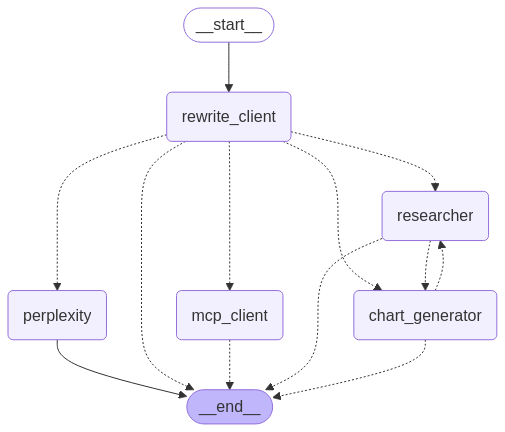

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Here: First, get the China's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.




2025-04-04 21:20:02,730 - httpx - INFO - HTTP Request: POST http://bedroc-proxy-mjagql6uvtpz-789127345.us-west-2.elb.amazonaws.com/api/v1/chat/completions "HTTP/1.1 200 OK"


NOW state after rewite: {'messages': [HumanMessage(content="First, get the China's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='3aab11d7-c8be-48cb-8d03-5dda6a7c6bef')]}


Before router_dispatcher: {'messages': [HumanMessage(content="First, get the China's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='3aab11d7-c8be-48cb-8d03-5dda6a7c6bef'), AIMessage(content='"Retrieve the GDP data for China over the past 10 years. Create a line chart to visualize this data. Once the chart is complete, the task is finished."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 111, 'total_tokens': 146, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'us.amazon.nova-lite-v1:0', 'system_fingerprint': 'fp', 'id': 'chatcmpl-9

2025-04-04 21:20:03,063 - httpx - INFO - HTTP Request: POST http://bedroc-proxy-mjagql6uvtpz-789127345.us-west-2.elb.amazonaws.com/api/v1/chat/completions "HTTP/1.1 200 OK"


After router_dispatcher: content='researcher' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 153, 'total_tokens': 154, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'us.amazon.nova-lite-v1:0', 'system_fingerprint': 'fp', 'id': 'chatcmpl-73371f82', 'finish_reason': 'stop', 'logprobs': None} id='run-d6743ed7-4e20-40a3-96f2-f032520160bb-0' usage_metadata={'input_tokens': 153, 'output_tokens': 1, 'total_tokens': 154, 'input_token_details': {}, 'output_token_details': {}}


... and type: <class 'langchain_core.messages.ai.AIMessage'>


{'rewrite_client': {'messages': AIMessage(content='"Retrieve the GDP data for China over the past 10 years. Create a line chart to visualize this data. Once the chart is complete, the task is finished."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 111, 'total_tokens': 146, 'completion_tokens

2025-04-04 21:20:06,600 - httpx - INFO - HTTP Request: POST http://bedroc-proxy-mjagql6uvtpz-789127345.us-west-2.elb.amazonaws.com/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-04 21:20:16,559 - httpx - INFO - HTTP Request: POST http://bedroc-proxy-mjagql6uvtpz-789127345.us-west-2.elb.amazonaws.com/api/v1/chat/completions "HTTP/1.1 200 OK"


{'researcher': {'messages': [HumanMessage(content="First, get the China's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='3aab11d7-c8be-48cb-8d03-5dda6a7c6bef'), AIMessage(content='"Retrieve the GDP data for China over the past 10 years. Create a line chart to visualize this data. Once the chart is complete, the task is finished."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 111, 'total_tokens': 146, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'us.amazon.nova-lite-v1:0', 'system_fingerprint': 'fp', 'id': 'chatcmpl-9a7c03f4', 'finish_reason': 'stop', 'logprobs': None}, id='run-d54c3f76-b2b6-4a47-a232-192cb0f54a23-0', usage_metadata={'input_tokens': 111, 'output_tokens': 35, 'total_tokens': 146, 'input_token_details': {}, 'output_token_details': {}}), AIMessage(content='', additional_kwargs

2025-04-04 21:20:34,509 - httpx - INFO - HTTP Request: POST http://bedroc-proxy-mjagql6uvtpz-789127345.us-west-2.elb.amazonaws.com/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-04 21:20:34,512 - langchain_experimental.utilities.python - WARNING - Python REPL can execute arbitrary code. Use with caution.


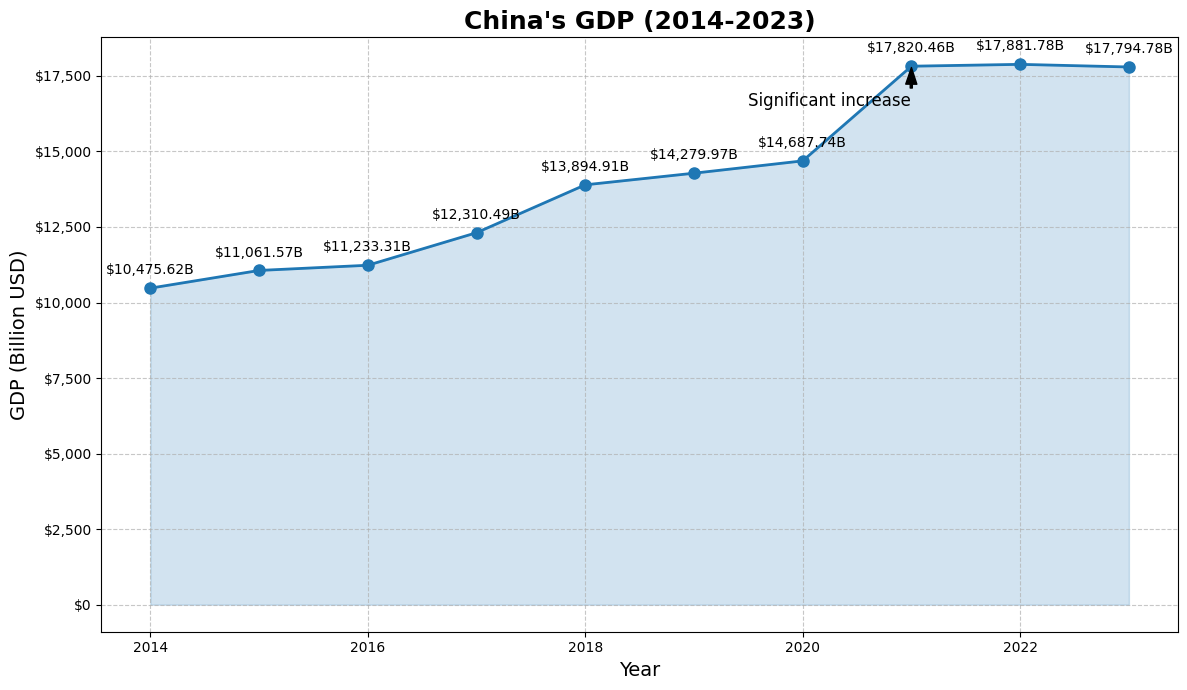

2025-04-04 21:20:43,264 - httpx - INFO - HTTP Request: POST http://bedroc-proxy-mjagql6uvtpz-789127345.us-west-2.elb.amazonaws.com/api/v1/chat/completions "HTTP/1.1 200 OK"


{'chart_generator': {'messages': [HumanMessage(content="First, get the China's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='3aab11d7-c8be-48cb-8d03-5dda6a7c6bef'), AIMessage(content='"Retrieve the GDP data for China over the past 10 years. Create a line chart to visualize this data. Once the chart is complete, the task is finished."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 111, 'total_tokens': 146, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'us.amazon.nova-lite-v1:0', 'system_fingerprint': 'fp', 'id': 'chatcmpl-9a7c03f4', 'finish_reason': 'stop', 'logprobs': None}, id='run-d54c3f76-b2b6-4a47-a232-192cb0f54a23-0', usage_metadata={'input_tokens': 111, 'output_tokens': 35, 'total_tokens': 146, 'input_token_details': {}, 'output_token_details': {}}), AIMessage(content='', additional_k

In [25]:
message_0 = [
            (
                "user",
                "First, get the China's GDP over the past 10 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ]

message_1 = [
            (
                "user",
                "Don't try to rewrite the question."
                "What is (2.4+54345.4545)*9563 ?",
            )
        ]

message_2 = [
            (
                "user",
                "During Trump's latest reciprocal tariff annoucement, which country will be levied the highest tariff rate?"
                "You might need to web search the latest news. ",
            )
        ]

message_3 = [
            (
                "user",
                "How is weather today in San Francisco?"
                "Please directly answer this question.",
            )
        ]

events = graph.astream(
    {
        "messages": message_0,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 15},
)
async for s in events:
    print(s)
    print("----")